<a href="https://colab.research.google.com/github/eaderogba/MP_Detection_ML/blob/main/Copy_of_Malaria_Detection_Demo_TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras import layers, Sequential
import os

2024-08-13 16:46:31.838792: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-13 16:46:31.843267: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-13 16:46:31.859227: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-13 16:46:31.882762: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-13 16:46:31.888805: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-13 16:46:31.905672: I tensorflow/core/platform/cpu_feature_gu

In [2]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
# Set path to Train and Test Directories
data_dir = '/content/drive/MyDrive/Colab Notebooks/cell_images'
test_path = '/content/drive/MyDrive/Colab Notebooks/Test_Model'

In [4]:
data_dir = "/home/eaderogba279/Bionformatics_Projects/MP_Detection_ML/Training"
test_path = "/home/eaderogba279/Bionformatics_Projects/MP_Detection_ML/Test"

In [5]:
# Specify parameters for batch size, image height and width
batch_size = 32
img_height = 128
img_width = 128

In [6]:
# Load tranining Dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=152,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='binary',
    class_names=['Parasitized', 'Uninfected'],
)

Found 3000 files belonging to 2 classes.
Using 2400 files for training.


In [7]:
# Load validation Dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=152,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='binary')

Found 3000 files belonging to 2 classes.
Using 600 files for validation.


2024-08-12 15:31:04.716106: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


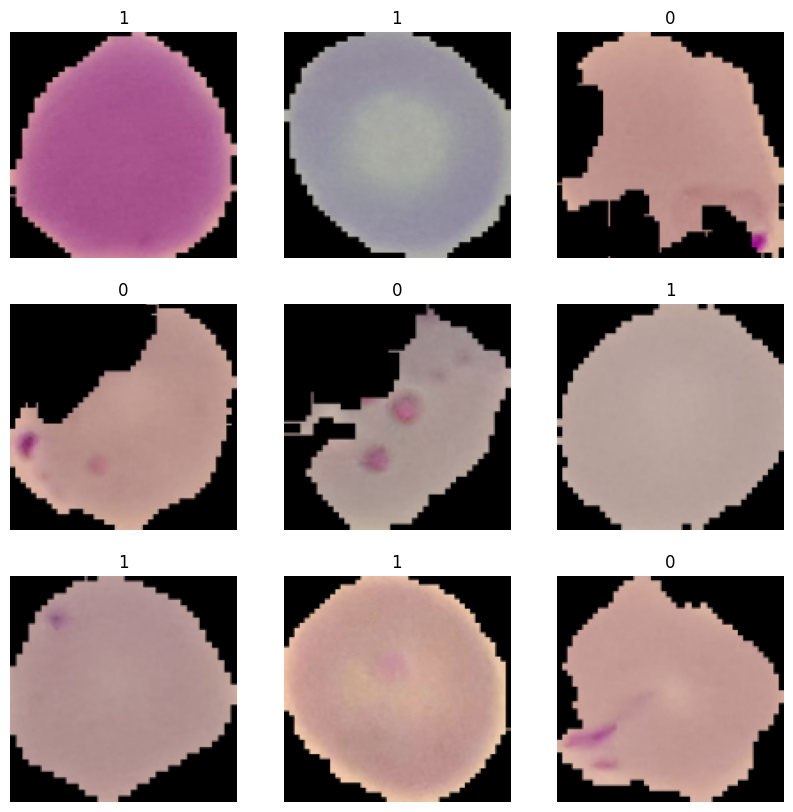

In [8]:
# Visualise the Training Dataset
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(int(labels[i]))
    plt.axis("off")

2024-08-12 15:31:18.929532: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


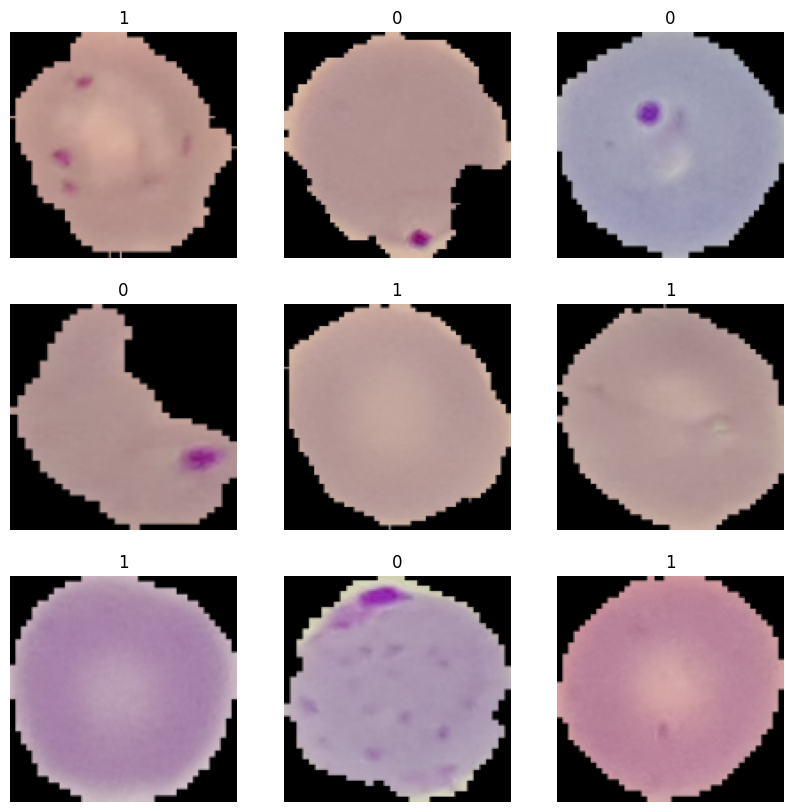

In [9]:
# Visualise the Validation Dataset
plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(int(labels[i]))
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 128, 128, 3)
(32, 1)


In [10]:
# Configure the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [44]:
# Create the model
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip('horizontal_and_vertical'),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomTranslation(height_factor=0.2, width_factor=0.2),
  layers.RandomContrast(0.2),
  layers.RandomBrightness(0.2)
])

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  data_augmentation,
  layers.Conv2D(32, 3, activation='relu', padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(32, 3, activation='relu', padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, 3, activation='relu', padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
  layers.MaxPooling2D((2, 2)),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])

/home/eaderogba279/Bionformatics_Projects/MP_Detection_ML/.venv/lib/python3.12/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [45]:
model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_6 (Rescaling)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_12 (Sequential)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,126,049 (8.11 MB)

 Trainable params: 2,126,049 (8.11 MB)

 Non-trainable params: 0 (0.00 B)

In [48]:
# Define EarlyStopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [49]:
# Compile the model
model.compile(
  optimizer='adam',
  loss=tf.losses.BinaryCrossentropy(from_logits=False),
  metrics=['accuracy'])

In [40]:
# Train the model with callback implementation
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=50,
  callbacks=[early_stop]
)

Epoch 1/50


75/75 ━━━━━━━━━━━━━━━━━━━━ 38s 471ms/step - accuracy: 0.5025 - loss: 1.2765 - val_accuracy: 0.5700 - val_loss: 0.8410
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 36s 472ms/step - accuracy: 0.5377 - loss: 0.8113 - val_accuracy: 0.5150 - val_loss: 0.7557
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 38s 510ms/step - accuracy: 0.5747 - loss: 0.7416 - val_accuracy: 0.5867 - val_loss: 0.7249
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 37s 499ms/step - accuracy: 0.5733 - loss: 0.7194 - val_accuracy: 0.5617 - val_loss: 0.7041
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 35s 474ms/step - accuracy: 0.5771 - loss: 0.7049 - val_accuracy: 0.6000 - val_loss: 0.6935
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 37s 493ms/step - accuracy: 0.5810 - loss: 0.6953 - val_accuracy: 0.5933 - val_loss: 0.6869
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 41s 551ms/step - accuracy: 0.5980 - loss: 0.6831 - val_accuracy: 0.5967 - val_loss: 0.6833
Epoch 8/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 43s 567ms/step - accuracy: 0.5997 - loss: 0.6773 - val_accuracy: 0.588

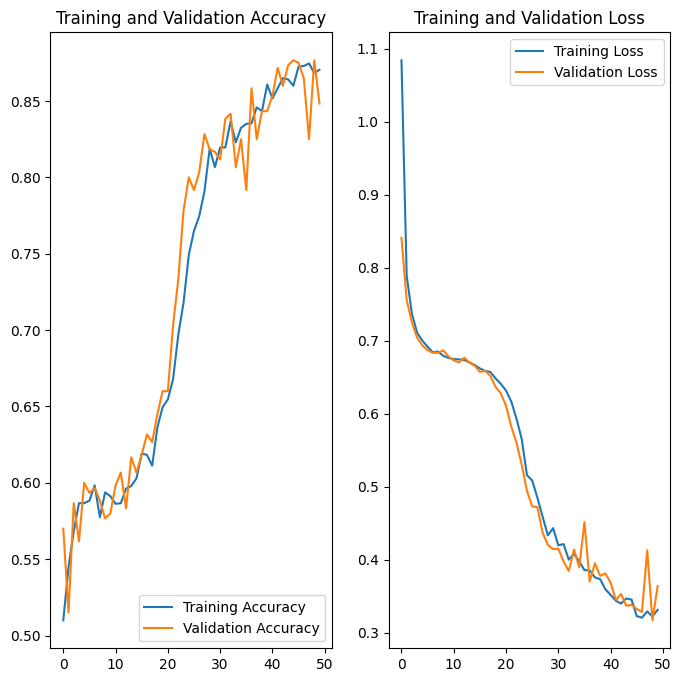

In [41]:
# Visualise training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [43]:
# List files in the directory
image_files = [f for f in os.listdir(test_path) if os.path.isfile(os.path.join(test_path, f))]

# Class names
class_names=['infected', 'uninfected']

for img_file in image_files:
  # Image path
  img_path = os.path.join(test_path, img_file)

  # Load and process images
  img = tf.keras.utils.load_img(img_path, target_size=(img_height, img_width))
  img_array = tf.keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch

  # Predict on New Data
  predictions = model.predict(img_array)
  score = tf.nn.sigmoid(predictions[0])

  confidence = score.numpy().item() * 100 if score.numpy().item() > 0.5 else (1 - score.numpy().item()) * 100
  predicted_class = class_names[int(score.numpy().item() > 0.5)]

  print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(predicted_class, confidence)
    )

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
This image most likely belongs to uninfected with a 61.81 percent confidence.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
This image most likely belongs to uninfected with a 50.34 percent confidence.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
This image most likely belongs to uninfected with a 72.69 percent confidence.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
This image most likely belongs to uninfected with a 72.11 percent confidence.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
This image most likely belongs to uninfected with a 70.59 percent confidence.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
This image most likely belongs to uninfected with a 72.93 percent confidence.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
This image most likely belongs to uninfected with a 60.85 percent confidence.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
This image most likely belongs to uninfected with a 54.32 percent confidence.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
This image most likely belongs to 